#### Explore missingness patterns in time-series measurements from medical history

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno as msno
import seaborn as sns
import pickle
from tqdm import tqdm

##### Load preprocessed multimodal features and mappings

In [54]:
events_test = pd.read_csv('../outputs/ext_data/events_ts.csv')

In [55]:
events_test[events_test.label=='Temperature']['value'].min()

86.0

In [4]:
def load_pickle(filepath: str):
    """Load a pickled object.

    Args:
        filepath (str): Path to pickle (.pkl) file.

    Returns:
        Any: Loaded object.
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data
embeddings = load_pickle("../outputs/prep_data/mmfair_feat.pkl")
#emb_new = load_pickle("../outputs/prep_data/mmfair_feat.pkl")
cols = load_pickle("../outputs/prep_data/mmfair_cols.pkl")
pt_ids = list(embeddings.keys())
measure_df = pd.DataFrame(columns=['pid', 'measure', 'value'])

In [ ]:
print(embeddings[pt_ids[2]]['dynamic_0'])
print(cols['dynamic0_cols'])
print(embeddings[pt_ids[2]]['dynamic_1'])
print(cols['dynamic1_cols'])

In [28]:
### Generate dataframe with preprocessed time-series measures in long format
rows = []
for pid in tqdm(pt_ids):
    ts_v = 0
    ts_b = 0
    for measure_set in embeddings[pid]['dynamic_0']:
        ts_v += 1
        for i in range(len(measure_set)):
            rows.append({'pid': pid, 'measure': cols['dynamic0_cols'][i], 'value': measure_set[i], 'timestep': ts_v})
    for measure_set in embeddings[pid]['dynamic_1']:
        ts_b += 1
        for i in range(len(measure_set)):
            rows.append({'pid': pid, 'measure': cols['dynamic1_cols'][i], 'value': measure_set[i], 'timestep': ts_b})
measure_df = pd.DataFrame(rows)

100%|██████████| 20130/20130 [00:04<00:00, 4192.91it/s]


In [29]:
measure_df.value = measure_df.value.astype(float).round(2)
measure_df.head(20)
vit_m_df = measure_df[measure_df['measure'].isin(['Diastolic blood pressure', 'Systolic blood pressure',
                                                 'Oxygen saturation', 'Heart rate', 'Respiratory rate',
                                                 'Temperature'])]
labs_m_df = measure_df[~measure_df['measure'].isin(['Diastolic blood pressure', 'Systolic blood pressure',
                                                 'Oxygen saturation', 'Heart rate', 'Respiratory rate',
                                                 'Temperature'])]

In [ ]:
vit_m_df.head()

In [ ]:
labs_m_df.head()

### Examine missingness patterns

In [ ]:
vit_m_df['is_missing'] = vit_m_df['value'] == -1  # True if Value is -1, else False
labs_m_df['is_missing'] = labs_m_df['value'] == -1  # True if Value is -1, else False
missing_pivot_labs = labs_m_df.pivot_table(
    index=['pid', 'timestep'],
    columns='measure',
    values='is_missing',
    aggfunc='first',
    fill_value=False
)
missing_pivot_vitals = vit_m_df.pivot_table(
    index=['pid', 'timestep'],
    columns='measure',
    values='is_missing',
    aggfunc='first',
    fill_value=False
)
# Visualize a single patient as an example
pid_example = measure_df['pid'].iloc[0]  # Pick the first patient for demonstration
subset = missing_pivot_labs.loc[pid_example]
plt.figure(figsize=(12, 8))
sns.heatmap(subset.T, cmap='viridis', cbar=True)
plt.title(f'Missingness per Measure for PID {pid_example} by Timestep')
plt.xlabel('Timestep')
plt.ylabel('Measurement')
plt.show()

Missingness by measure name:
 measure
Anion Gap            26.835372
Sodium               23.923311
PTT                  19.028984
Potassium            18.110942
Phosphate            10.649057
Calcium Total        10.089927
Magnesium            10.001953
Platelet Count        7.157768
Bicarbonate           0.768258
White Blood Cells     0.720289
Hematocrit            0.702656
Chloride              0.438544
MCV                   0.435890
Creatinine            0.379389
RDW                   0.210456
MCHC                  0.205716
MCH                   0.205147
Red Blood Cells       0.200407
Hemoglobin            0.189031
Urea Nitrogen         0.179741
dtype: float64


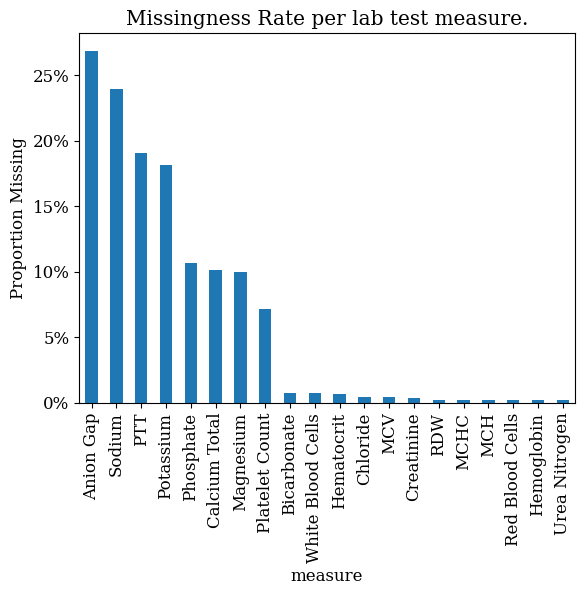

In [36]:
missing_rates = missing_pivot_labs.mean().sort_values(ascending=False) * 100
print("Missingness by measure name:\n", missing_rates)

plt.rcParams.update(
        {"font.size": 12, "font.weight": "normal", "font.family": "serif"}
    )
# Plot overall missingness per measurement type
missing_rates.plot(kind='bar')
plt.ylabel('Proportion Missing')
plt.title('Missingness Rate per lab test measure.')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

Missingness by measure name:
 measure
Temperature                 5.647082
Oxygen saturation           1.625463
Diastolic blood pressure    0.366330
Systolic blood pressure     0.366330
Respiratory rate            0.358322
Heart rate                  0.192173
dtype: float64


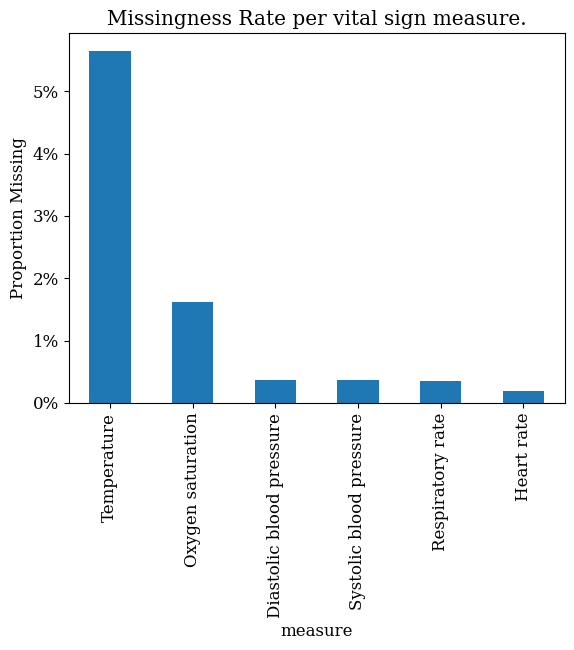

In [37]:
missing_rates = missing_pivot_vitals.mean().sort_values(ascending=False) * 100
print("Missingness by measure name:\n", missing_rates)

plt.rcParams.update(
        {"font.size": 12, "font.weight": "normal", "font.family": "serif"}
    )
# Plot overall missingness per measurement type
missing_rates.plot(kind='bar')
plt.ylabel('Proportion Missing')
plt.title('Missingness Rate per vital sign measure.')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

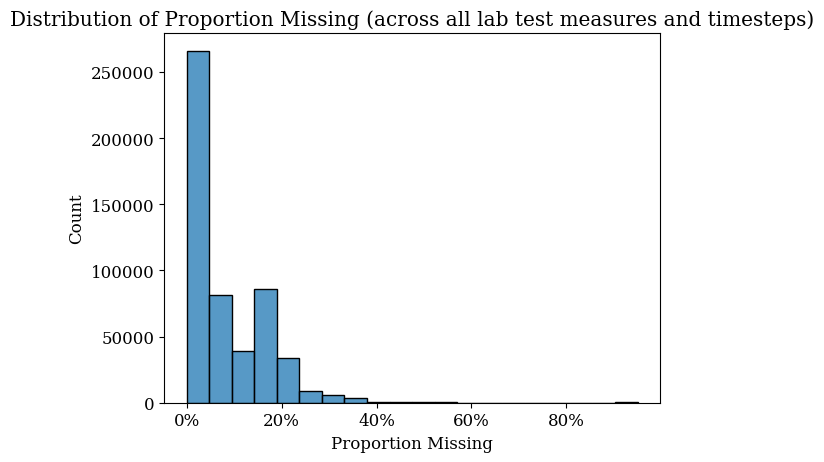

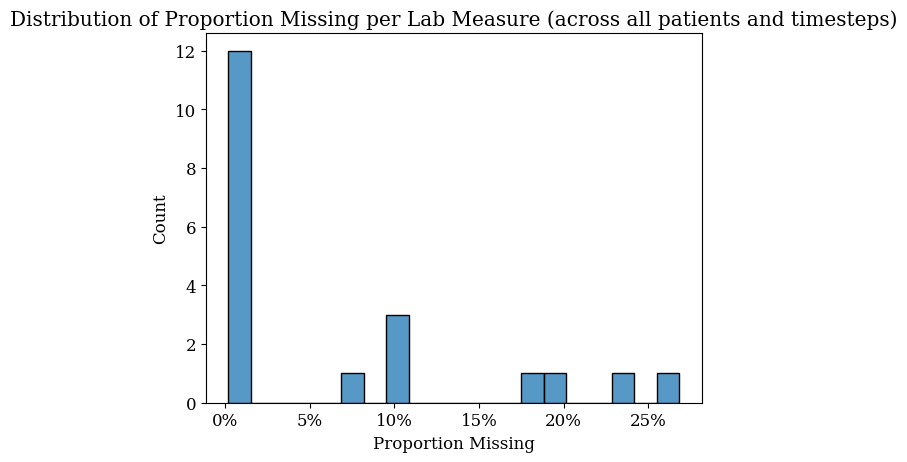

In [39]:
# Proportion missing per patient
missing_by_patient = missing_pivot_labs.mean(axis=1) * 100
sns.histplot(missing_by_patient, bins=20)
plt.title('Distribution of Proportion Missing (across all lab test measures and timesteps)')
plt.xlabel('Proportion Missing')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

# Proportion missing per timestep
missing_by_timestep = missing_pivot_labs.mean(axis=0) * 100
sns.histplot(missing_by_timestep, bins=20)
plt.title('Distribution of Proportion Missing per Lab Measure (across all patients and timesteps)')
plt.xlabel('Proportion Missing')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

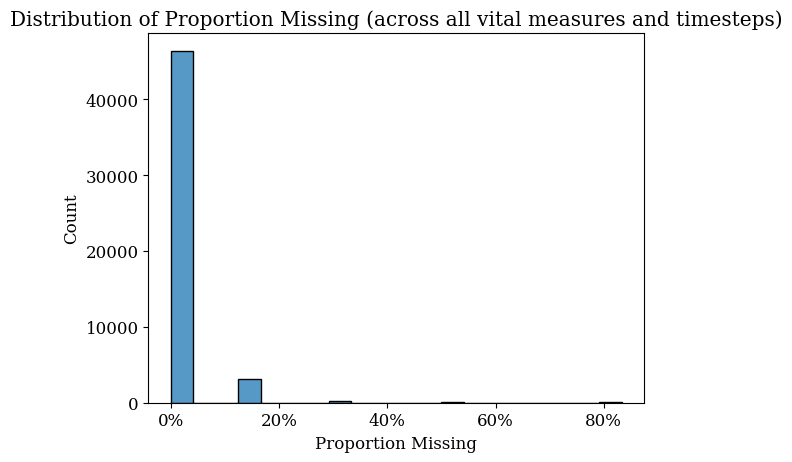

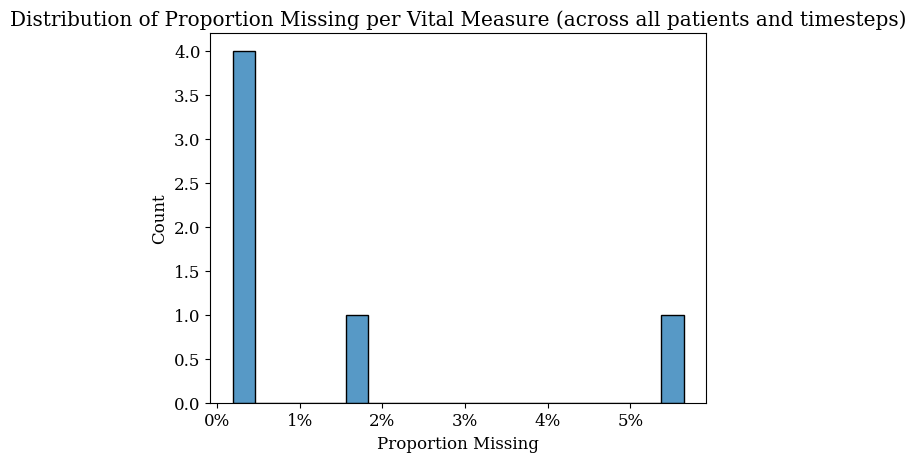

In [50]:
# Proportion missing per patient
missing_by_patient = missing_pivot_vitals.mean(axis=1) * 100
sns.histplot(missing_by_patient, bins=20)
plt.title('Distribution of Proportion Missing (across all vital measures and timesteps)')
plt.xlabel('Proportion Missing')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

# Proportion missing per timestep
missing_by_timestep = missing_pivot_vitals.mean(axis=0) * 100
sns.histplot(missing_by_timestep, bins=20)
plt.title('Distribution of Proportion Missing per Vital Measure (across all patients and timesteps)')
plt.xlabel('Proportion Missing')
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
plt.show()

In [ ]:
labs_m_df.head()

In [ ]:
df_nan

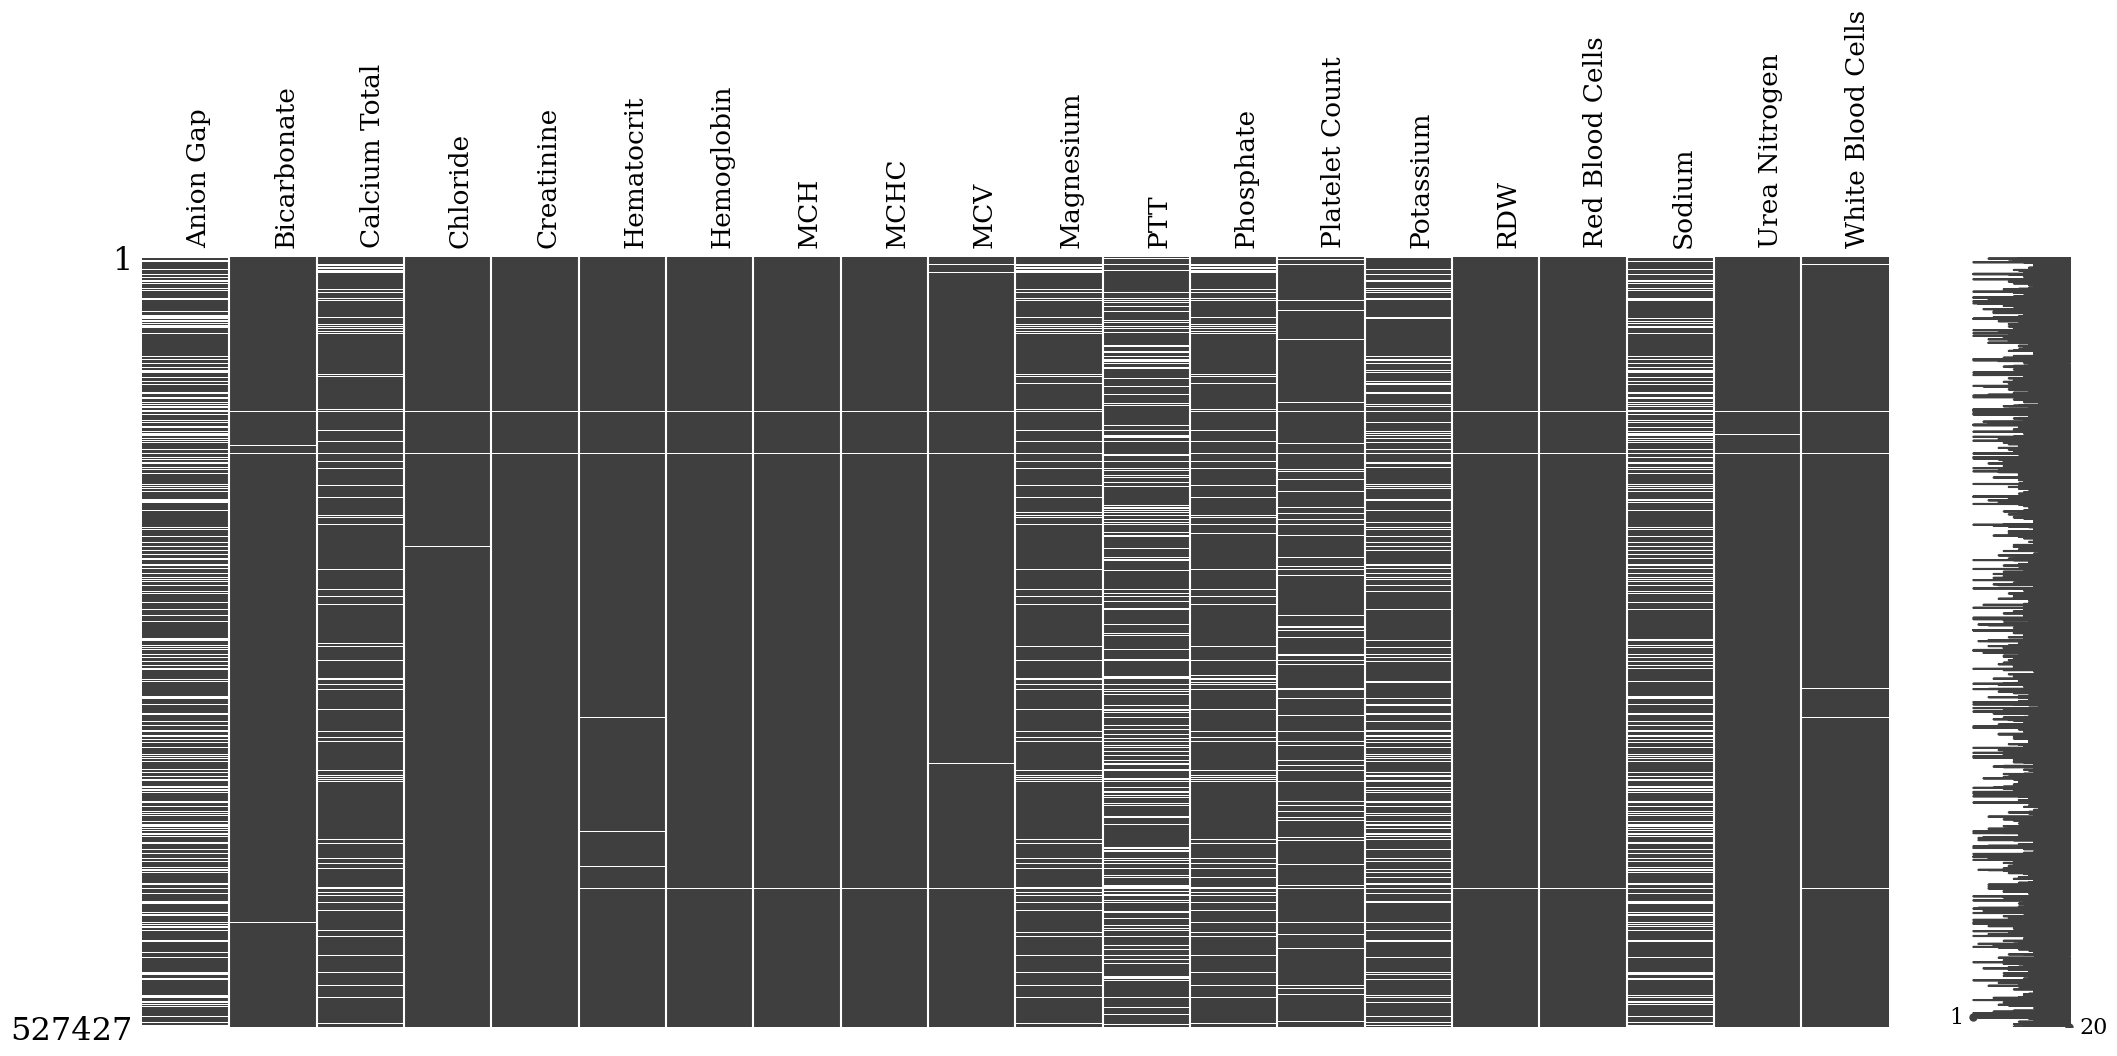

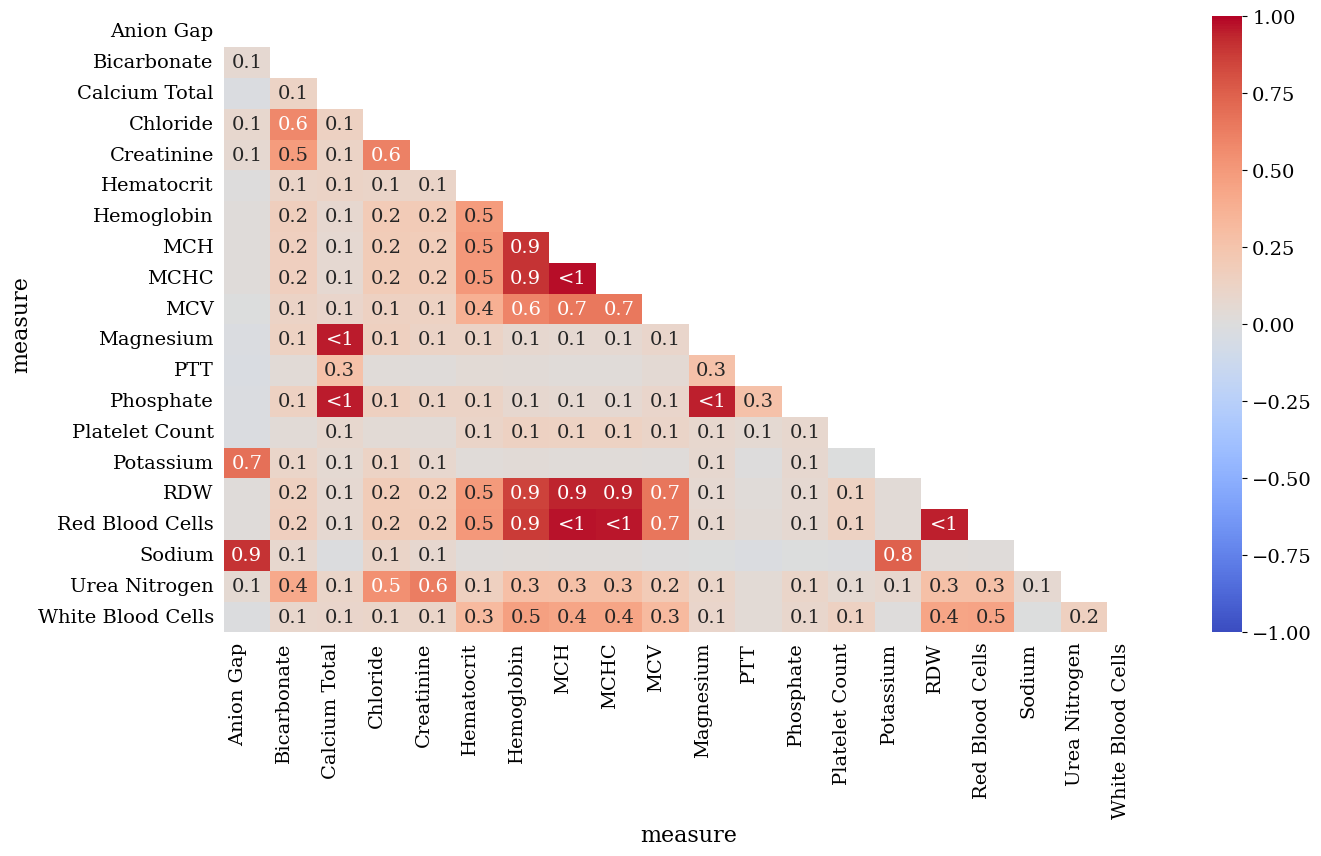

In [64]:
df_nan = labs_m_df.copy()
df_nan.loc[df_nan['value'] == -1, 'value'] = np.nan
missing_pivot = df_nan.pivot_table(
    index=['pid', 'timestep'],
    columns='measure',
    values='value',
    aggfunc='first'
).reset_index()
pivot_reset = missing_pivot.reset_index(drop=True)
# Exclude index columns (pid, timestep) from the matrix visualization
matrix_data = pivot_reset.drop(columns=['pid', 'timestep'])
msno.matrix(matrix_data, fontsize=19, label_rotation=90)
plt.show()

# Create heatmap with larger font sizes and rotated x-axis labels
fig, ax = plt.subplots(figsize=(15, 8))
msno.heatmap(matrix_data, cmap='coolwarm', ax=ax)
ax.tick_params(axis='x', labelsize=14, rotation=90)  # Increase x-axis tick font size and rotate 90 degrees
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # Increase y-axis label font size

# Increase colorbar (legend) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.show()

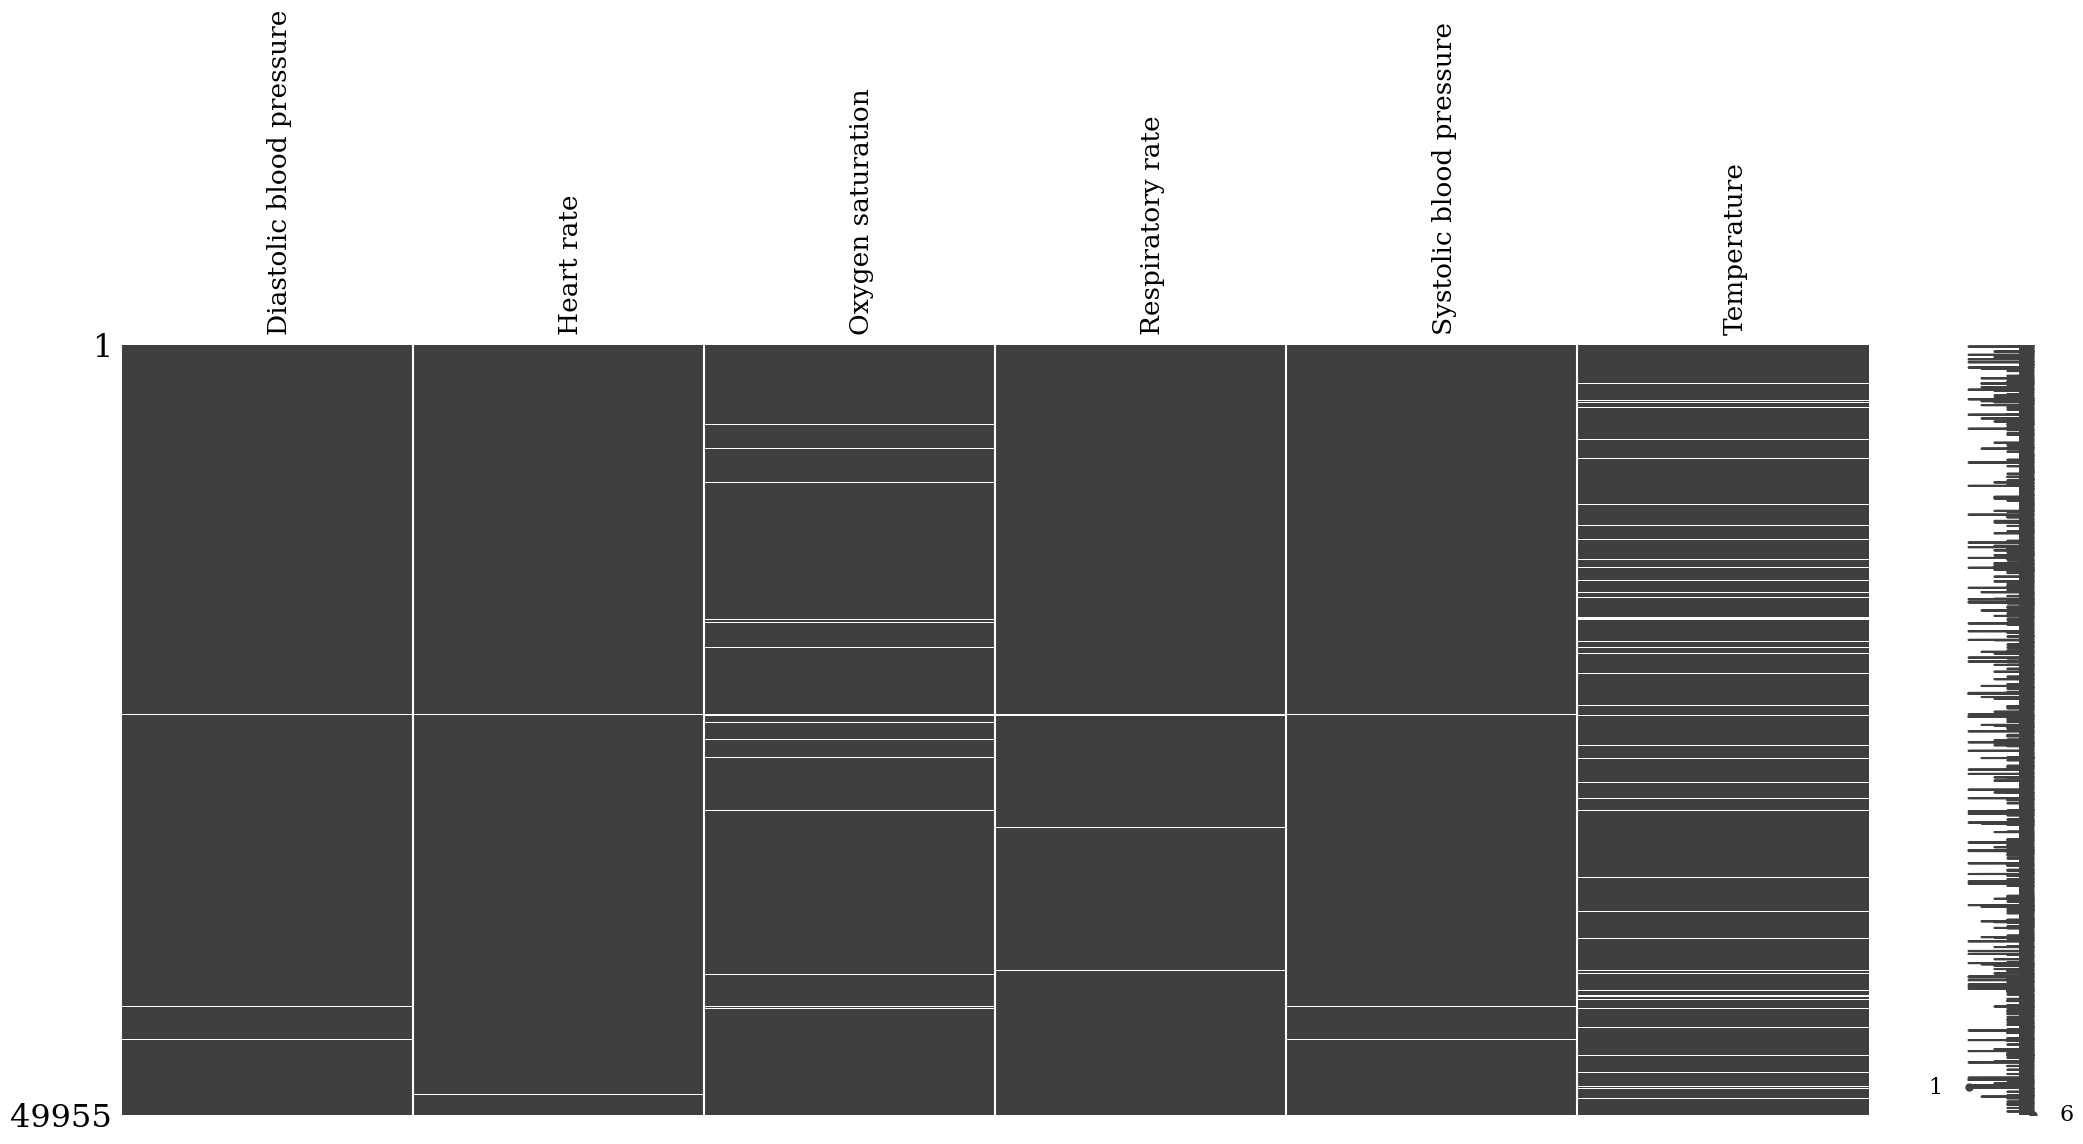

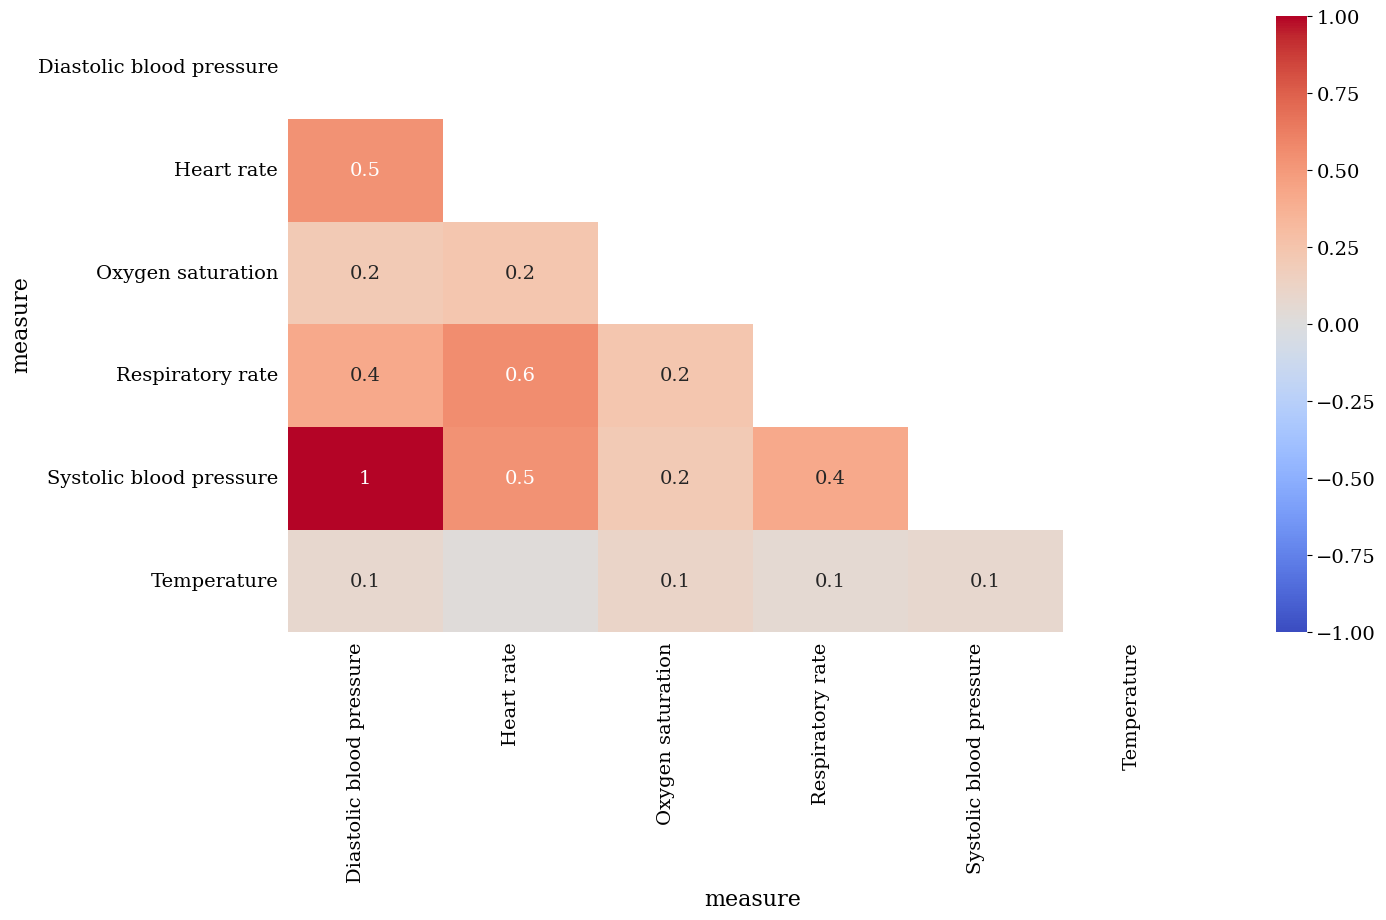

In [65]:
df_nan = vit_m_df.copy()
df_nan.loc[df_nan['value'] == -1, 'value'] = np.nan
missing_pivot = df_nan.pivot_table(
    index=['pid', 'timestep'],
    columns='measure',
    values='value',
    aggfunc='first'
).reset_index()
pivot_reset = missing_pivot.reset_index(drop=True)
# Exclude index columns (pid, timestep) from the matrix visualization
matrix_data = pivot_reset.drop(columns=['pid', 'timestep'])
msno.matrix(matrix_data, fontsize=19, label_rotation=90)
plt.show()

# Create heatmap with larger font sizes and rotated x-axis labels
fig, ax = plt.subplots(figsize=(15, 8))
msno.heatmap(matrix_data, cmap='coolwarm', ax=ax)
ax.tick_params(axis='x', labelsize=14, rotation=90)  # Increase x-axis tick font size and rotate 90 degrees
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # Increase y-axis label font size

# Increase colorbar (legend) font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.show()